In [76]:
from __future__ import annotations

import datetime
import hashlib
import itertools
import json
import os
import pickle
import re
import warnings

from collections import namedtuple
from copy import copy
from functools import partial
from pathlib import Path
from typing import List

In [77]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import joblib

import matplotlib as mpl
from matplotlib import gridspec
from matplotlib import pyplot as plt

import netCDF4
from netCDF4 import Dataset

import numpy as np

import pandas as pd

import scipy as sp
from scipy import stats
import sklearn
from sklearn.covariance import EmpiricalCovariance
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import tqdm

In [78]:
# DATASETS = dict()

In [79]:
# PERTURBED_DATASETS = dict()

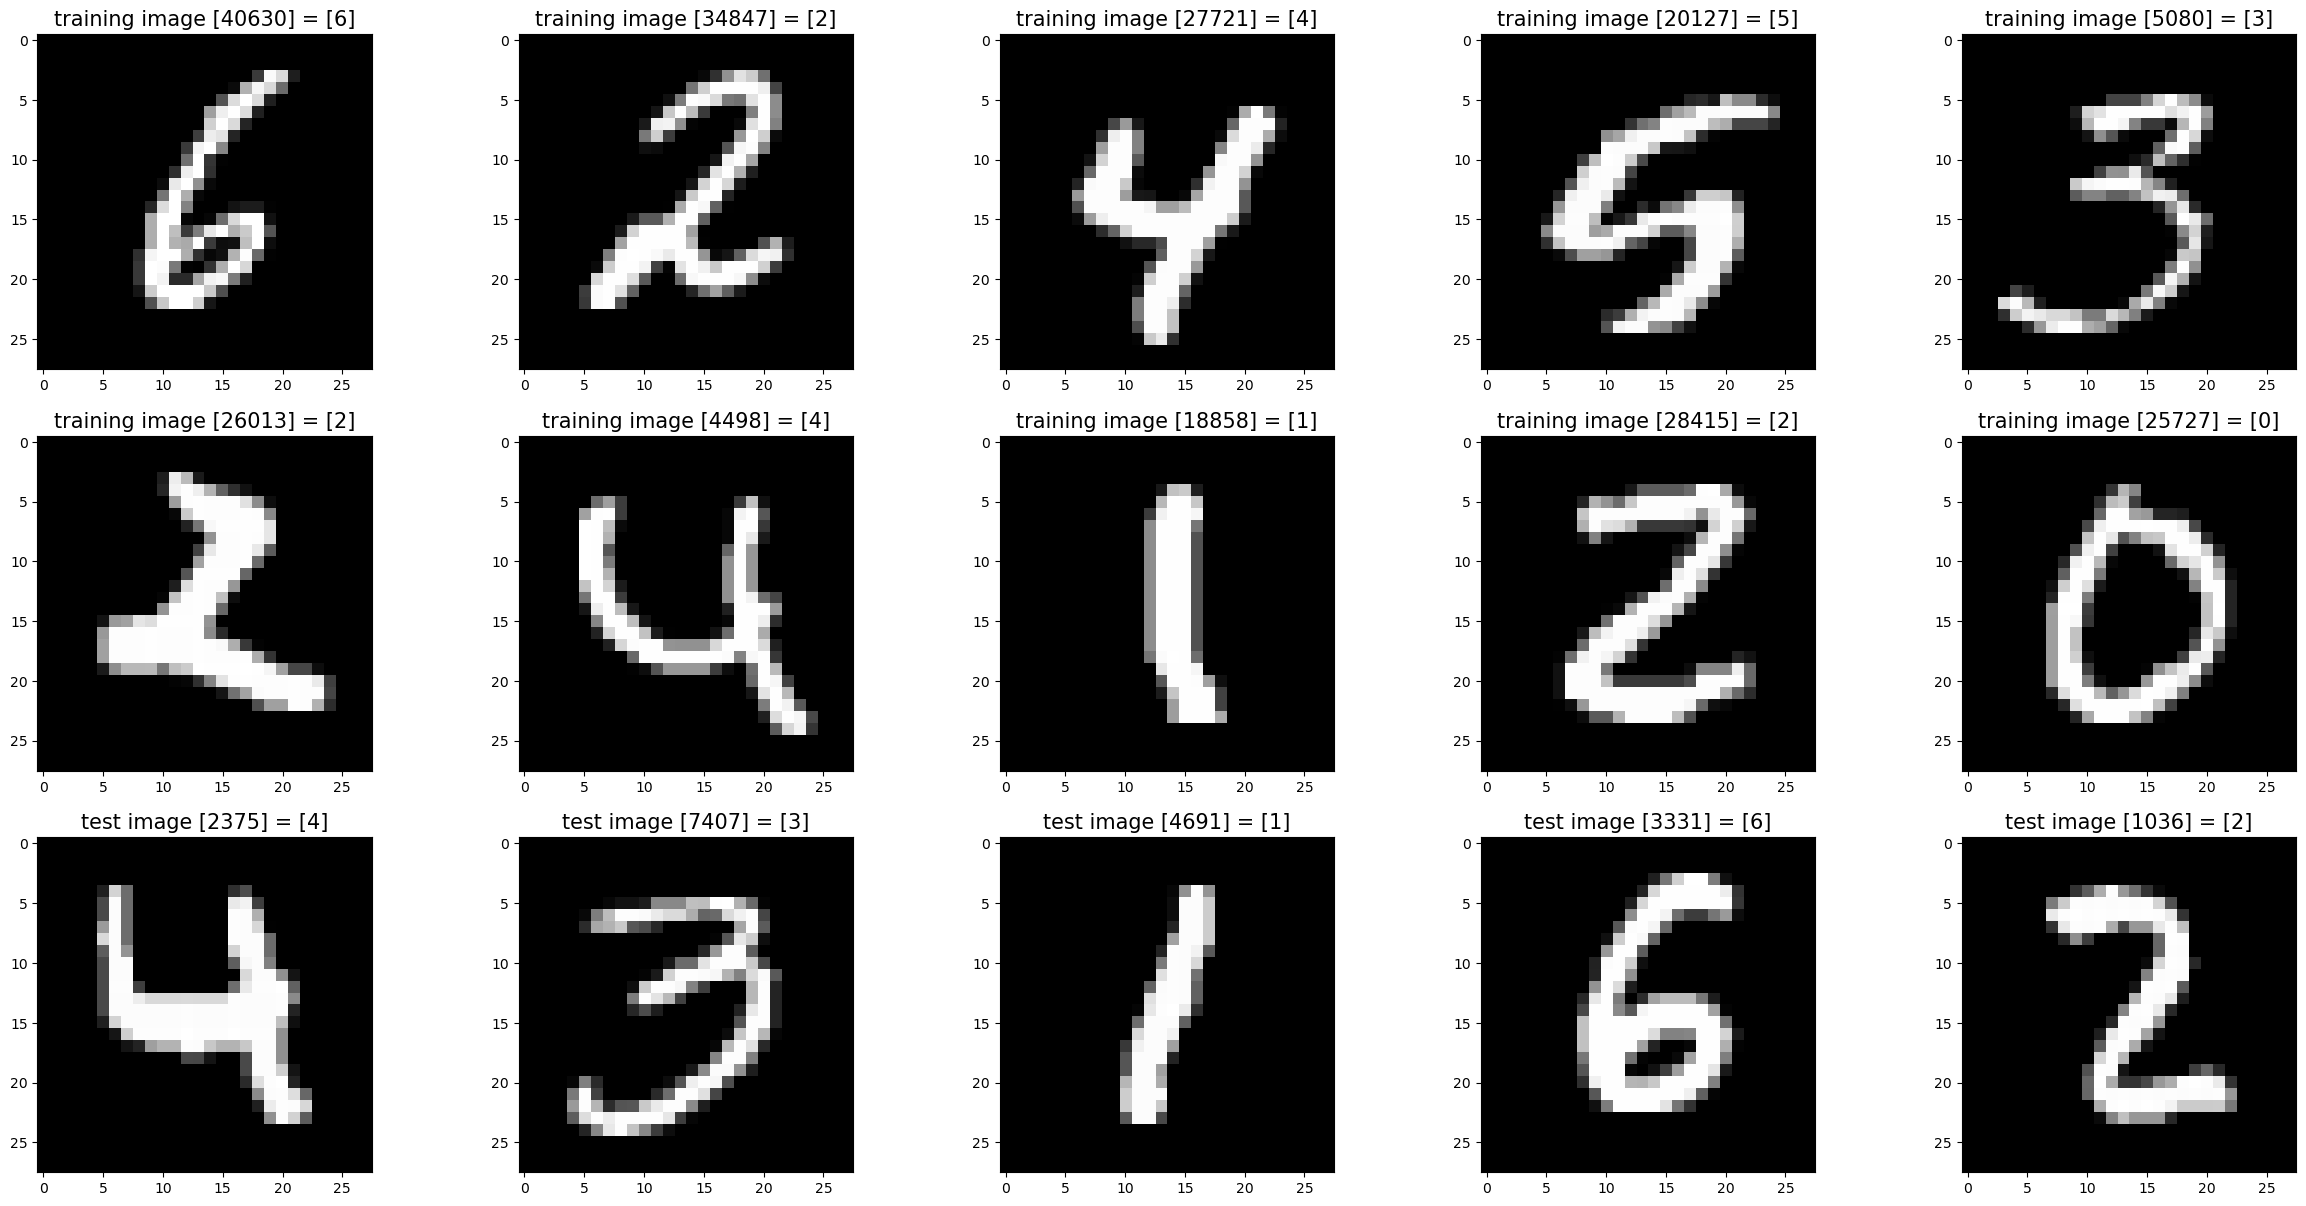

In [80]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
# Dataset : https://www.kaggle.com/datasets/hojjatk/mnist-dataset
# Script : https://www.kaggle.com/code/hojjatk/read-mnist-dataset
# 
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath, flag):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        data_imgs = []
        labels_l = []
        pic_imgs = []
        indxs = []
        
        for i in range(size):
            if (flag and (labels[i] in [7, 8, 9])):
                continue
            else:
                data_imgs.append([0] * rows * cols)
                pic_imgs.append([0] * rows * cols)
                labels_l.append(labels[i])
                indxs.append(i)
                
        for i in range(len(indxs)):# range(size):
            img = np.array(image_data[indxs[i] * rows * cols:(indxs[i] + 1) * rows * cols])
            img_flat = img.reshape(28, 28).flatten()
            img = img.reshape(28, 28)
            data_imgs[i][:] = img_flat
            pic_imgs[i][:] = img
        
        return np.array(data_imgs), np.array(labels_l).reshape(-1, 1), np.array(pic_imgs)
            
    def load_data(self):
        x_train, y_train, x_train_img = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath, True)
        x_test, y_test, x_test_img = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath, False)
        return (x_train, y_train),(x_test, y_test), (x_train_img, x_test_img)      
#
# Verify Reading Dataset via MnistDataloader class
# %matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'mnist_dataset'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15)  
        index += 1
        
#
# Load MINST dataset
#
def load_dataset():
    mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
    (x_train, y_train), (x_test, y_test), (x_train_img, x_test_img) = mnist_dataloader.load_data()
    return (x_train, y_train), (x_test, y_test), (x_train_img, x_test_img)


(x_train, y_train), (x_test, y_test), (x_train_img, x_test_img)    = load_dataset()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, len(x_train_img))
    images_2_show.append(x_train_img[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, len(x_test_img))
    images_2_show.append(x_test_img[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

plt.show()

DATASETS = dict() # DATASET(x_train, y_train, x_test, y_test)

In [81]:
MLDataset = namedtuple("MLDataset", ["X_raw", "Y_raw", "X_train", "X_valid", "X_test", "Y_train", "Y_valid", "Y_test", "X_scaler", "train_imgs", "test_imgs"])

"""
Clumped 0/1 sampler using a Markov Process

P(0) = p and P(1) = 1-p
clump = 0 => IID samples
clump -> 1 => highly correlated samples

"""
class Clump:
    def __init__(self, p=0.5, clump=0.0, rng=None):
        a = 1 - (1-p)*(1-clump)
        b = (1-a)*p/(1-p)
        
        self.C = np.array([[a, 1-a],[b, 1-b]])
        
        self.i = 0 if rng.random() < p else 1
    
    def sample(self, rng):
        p = self.C[self.i,0]
        u = rng.random()
        
        self.i = 0 if u < p else 1
        
        return self.i
    
    def steady(self, X):
        return np.matmul(X, self.C)

def train_test_split(X, Y, test_size=0.25, random_state=None, shuffle=True, clump=0.0):
    assert len(X) == len(Y)
    assert type(X) == type(Y)
    assert test_size > 0.0
    assert test_size < 1.0
    assert random_state is not None
    assert clump >= 0.0
    assert clump < 1.0
    
    
    c = Clump(p=test_size, clump=clump, rng=random_state)
    
    if isinstance(X, pd.DataFrame):
        assert X.index.values.shape == Y.index.values.shape
        
        # Split only based on the first-level index instead of flattening
        n1 = len(X.index.levels[1])
        n0 = len(X) // n1
        
        C = np.array([c.sample(random_state) for _ in range(n0)])
        I_train, = np.nonzero(C)
        I_train = np.repeat(I_train, n1) * n1 + np.tile(np.arange(n1), len(I_train))
        I_test, = np.nonzero(1-C)
        I_test = np.repeat(I_test, n1) * n1 + np.tile(np.arange(n1), len(I_test))
    else:
        C = np.array([c.sample(random_state) for _ in range(len(X))])
        I_train, = np.nonzero(C)
        I_test, = np.nonzero(1-C)
    
    if shuffle:
        random_state.shuffle(I_train)
        random_state.shuffle(I_test)
    
    if isinstance(X, pd.DataFrame):
        X_train = X.iloc[I_train]
        X_test = X.iloc[I_test]
        
        Y_train = Y.iloc[I_train]
        Y_test = Y.iloc[I_test]
    else:
        X_train = X[I_train]
        X_test = X[I_test]
        
        Y_train = Y[I_train]
        Y_test = Y[I_test]
    
    # print(X_train.shape)
    # print(Y_train.shape)
    
    return X_train, X_test, Y_train, Y_test

def load_and_cache_dataset(clump: float, datasets: dict) -> MLDataset:
    
    cached = datasets.get((clump))
    
    if cached is not None:
        return cached
    # dp = get_path_for_perturbation(dt, Path("baseline"))
    # ds = load_trajectory_dataset(dp)

    # X_raw = get_raw_features_for_dataset(ds)

    # (X_raw, Y_raw) = read_data('digit_dataset/training_data')
    (X_raw, Y_raw), (test_features, test_labels), (train_img, test_img) = load_dataset()
        
    # X = get_features_from_raw_features(X_raw)
    # Y = np.log10(get_labels_for_dataset(ds) + 1)

    rng = np.random.RandomState(seed=0)
        
    # train_features, test_features, train_labels, test_labels = train_test_split(
    #     X_raw, Y_raw, test_size=0.25, random_state=rng, clump=clump,
    # )
    # print(type(X_raw), type(Y_raw))
    # print(Y_raw[0])
    train_features, valid_features, train_labels, valid_labels = train_test_split(
        X_raw, Y_raw, test_size=1.0/3.0, random_state=rng, clump=clump,
    )

    # Scale features to N(0,1)
    # - only fit on training data
    # - OOD inputs for constants at training time are blown up
    # feature_scaler = 0
    feature_scaler = StandardScaler().fit(train_features)
    feature_scaler.scale_[np.nonzero(feature_scaler.var_ == 0.0)] = np.nan_to_num(np.inf)

    # label_scaler = StandardScaler().fit(train_labels)

    train_features = feature_scaler.transform(train_features)
    # train_labels = label_scaler.transform(train_labels)
    valid_features = feature_scaler.transform(valid_features)
    # valid_labels = label_scaler.transform(valid_labels)
    test_features = feature_scaler.transform(test_features)
    # test_labels = label_scaler.transform(test_labels)
    
    dataset = MLDataset(
        X_raw=X_raw, Y_raw=Y_raw,
        X_train=train_features, X_valid=valid_features, X_test=test_features,
        Y_train=train_labels, Y_valid=valid_labels, Y_test=test_labels,
        X_scaler=feature_scaler, train_imgs=train_img, test_imgs=test_img
    )

    datasets[(clump)] = dataset
    
    return dataset

In [82]:
import abc

IcarusPrediction = namedtuple("IcarusPrediction", ["prediction", "uncertainty", "confidence"])

class IcarusRSM(abc.ABC):
    @abc.abstractmethod
    def fit(
        self,
        X_train: np.ndarray, Y_train: np.ndarray,
        X_valid: np.ndarray, Y_valid: np.ndarray,
        rng: np.random.Generator, **kwargs,
    ) -> IcarusRSM:
        return self
    
    @abc.abstractmethod
    def predict(self, X_test: np.ndarray, rng: np.random.Generator, **kwargs) -> IcarusPrediction:
        return None

In [83]:
class RandomForestNumbersRSM(IcarusRSM):
    def fit(
        self,
        X_train: np.ndarray, Y_train: np.ndarray,
        X_valid: np.ndarray, Y_valid: np.ndarray,
        rng: np.random.Generator,
        n_trees: int = 16, verbose: int = 1,
    ) -> RandomForestNumbersRSM:
        assert Y_train.shape[1:] == (1,)
        
        if verbose > 0:
            print("Training the RandomForestNumbersRSM")

            print(" - Training the OOD detector")
            print("   - Fitting truncated PCA")
        
        self.pca = PCA(random_state=rng).fit(X_train)
        self.bn = np.searchsorted(np.cumsum(self.pca.explained_variance_ratio_), 0.95)
        
        if verbose > 0:
            print("   - Fitting truncated PCA reconstruction error covariance")
        
        self.cov = EmpiricalCovariance().fit((self._predict_truncated_pca(X_train) - X_train))
        
        if verbose > 0:
            print("   - Generating FGSM OOD inputs")
        
        adv_grad = self.pca.components_[self.bn]
        
        X_ood = rng.normal(loc=X_valid, scale=0.01) + np.sign(adv_grad) * np.abs(
            rng.normal(loc=2.0, scale=0.5, size=(len(X_valid), 1))
        ) * rng.choice([-1, 1])
        
        if verbose > 0:
            print("   - Training the OOD classifier")
        
        M_id = self.cov.mahalanobis(self._predict_truncated_pca(X_valid) - X_valid)
        M_ood = self.cov.mahalanobis(self._predict_truncated_pca(X_ood) - X_ood)
        
        self.scaler = StandardScaler().fit(M_id.reshape(-1, 1))
        
        self.ood_detector = LogisticRegression(
            penalty='none', class_weight="balanced", random_state=rng,
        ).fit(
            np.concatenate([
                self.scaler.transform(M_id.reshape(-1, 1)),
                self.scaler.transform(M_ood.reshape(-1, 1)),
            ], axis=0).reshape(-1, 1),
            np.concatenate([
                np.ones(len(M_id)), np.zeros(len(M_ood)),
            ], axis=0),
        )
        
        if verbose > 0:
            print(" - Training the Prediction Model and Uncertainty Quantifier")
        
        self.predictor = RandomForestClassifier(
            n_estimators=n_trees, random_state=rng, n_jobs=-1, min_samples_leaf=5,
            max_features=1.0/3.0, verbose=verbose,
        ).fit(X_train, Y_train.ravel())
        
        if verbose > 0:
            print(" - Finished training the RandomForestNumbersRSM")
        
        return self
    
    def predict(
        self, X_test: np.ndarray, rng: np.random.Generator, verbose: int = 2,
    ) -> IcarusPrediction:
        # No extra randomness is needed during prediction
        _rng = rng
        
        if verbose > 1:
            print("Predicting with the RandomForestNumbersRSM")
            
            print(" - Generating confidence scores")
        
        confidence = self.ood_detector.predict_proba(self.scaler.transform(
            self.cov.mahalanobis(self._predict_truncated_pca(X_test) - X_test).reshape(-1, 1)
        ))[:,1]
            
        if verbose > 1:
            print(" - Generating ensemble predictions")
            
        def tree_predict(i: int) -> np.ndarray:
            if verbose > 1:
                print(f"   - Predicting tree {i}/{len(self.predictor.estimators_)}")
            
            return self.predictor.estimators_[i].predict(X_test)
        
        predictions = joblib.Parallel(n_jobs=-1, prefer="threads")(
            joblib.delayed(tree_predict)(i) for i in range(len(self.predictor.estimators_))
        )
        
        # print("Size of pred: ", np.array(predictions).shape)

        prediction = stats.mode(np.array(predictions), axis=0, keepdims=False)[0].reshape((len(X_test), 1))
        # print(prediction.shape)
        uncertainty = 1 - stats.mode(np.array(predictions), axis=0, keepdims=False)[1].reshape((len(X_test), 1)) / 16
        
        if verbose > 1:
            print(" - Finished predicting with the RandomForestNumbersRSM")
            
        return IcarusPrediction(
            prediction=prediction, uncertainty=uncertainty, confidence=confidence,
        )

    def _predict_truncated_pca(self, X: np.ndarray) -> np.ndarray:
        if self.pca.mean_ is not None:
            X = X - self.pca.mean_
        
        X_trans = np.dot(X, self.pca.components_[:self.bn].T)
        X = np.dot(X_trans, self.pca.components_[:self.bn])
        
        if self.pca.mean_ is not None:
            X = X + self.pca.mean_
        
        return X

In [84]:
def train_and_cache_model(clump: float, datasets: dict, models: dict, cls, **kwargs):
    model_key = (cls.__name__, clump)
    
    cached = models.get(model_key)
    
    if cached is not None:
        return cached
    
    model_path = f"{cls.__name__.lower()}.icarus.no789.jl"
    
    if Path(model_path).exists():
        try:
            model = joblib.load(model_path)
            
            models[model_key] = model
        
            return model
        except:
            pass
    
    dataset = load_and_cache_dataset(clump, datasets)
    # dataset = datasets
    
    rng = np.random.RandomState(seed=0)
    
    model = cls().fit(
        X_train=dataset.X_train, Y_train=dataset.Y_train,
        X_valid=dataset.X_valid, Y_valid=dataset.Y_valid,
        rng=rng, **kwargs,
    )
    
    joblib.dump(model, model_path)
    
    models[model_key] = model
    
    return model

In [85]:
RANDOM_FOREST_MODELS = dict()
# DATASETS.X_train
        
train_and_cache_model(0.75, DATASETS, RANDOM_FOREST_MODELS, RandomForestNumbersRSM)


In [86]:
class Table:
    def __init__(self, filepath, keys=[]):
        self.filepath = filepath
        
        self.cols = { k: [] for k in keys }
    
    def __enter__(self):
        return self
    
    def insert(self, **kwargs):
        for k, v in kwargs.items():
            self.cols[k].append(v)
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_val is None:
            df = pd.DataFrame(self.cols)
            df.to_csv(self.filepath, header=True, index=False)
        
        return False
            
    def backup(self):
        df = pd.DataFrame(self.cols)
        df.to_csv(self.filepath, header=True, index=False)

In [87]:
def analyse_icarus_predictions(
    predictions: List[IcarusPrediction],
    analysis: Callable[[List[np.ndarray], np.ndarray, np.random.Generator, dict], np.ndarray],
    rng: np.random.Generator,
    n_uncertain_samples: int = 1,  # number of samples to draw from expand each prediction per run
    n_analysis_runs: int = 100,  # number of repeats of the analysis to gather uncertainty
    **kwargs,
):
    assert len(predictions) > 0
    
    # predictions that need to coexist multiply their confidence
    prod_confidence = np.prod([p.confidence for p in predictions], axis=0)
    # independent predictions average their confidence
    confidence = np.mean(prod_confidence)

    results = []
    # for _ in range(n_analysis_runs):
    #     confs = []
    #     preds = [[] for _ in predictions]
    #     for _ in range(n_uncertain_samples):
    #         I_conf = (
    #             rng.random(size=prod_confidence.shape) <= prod_confidence
    #         )
    #         (I_conf,) = np.nonzero(I_conf)

    #         confs.append(I_conf)
    #         
    #         for i, p in enumerate(predictions):
    #             preds[i].append(
    #                 rng.normal(
    #                     loc=p.prediction[I_conf],
    #                     scale=p.uncertainty[I_conf],
    #                 )
    #             )
    #     confs = np.concatenate(confs, axis=0)
    #     preds = [
    #         np.concatenate(p, axis=0) for p in preds
    #     ]

    #     results.append(analysis(preds, confs, rng, **kwargs))
    
    # if (0 == 1):
    #    prediction = stats.mode(np.stack(results, axis=0), keepdims=False)[0]
    #    uncertainty = np.std(np.stack(results, axis=0), axis=0)
    #    # print("With analysis:", prediction, uncertainty)
    # else:
    prediction = stats.mode(predictions[0].prediction, axis=0, keepdims=False)[0].flatten() # 
    uncertainty = np.mean(predictions[0].uncertainty) # np.std(np.stack(results, axis=0), axis=0)
        
    return IcarusPrediction(
        prediction=prediction,
        uncertainty=uncertainty,
        confidence=confidence,
    )

In [88]:
def combine_many_icarus_predictions(
    model: IcarusRSM,
    X_test: np.ndarray,
    rng: np.random.Generator,
    n_samples: int,
    n_uncertain_samples: int, # number of samples to draw from expand each prediction per run
    n_analysis_runs: int, # number of repeats of the analysis to gather uncertainty
    **kwargs,
) -> IcarusPrediction:
    model_predictions = []
    
    for i in range(n_samples):
        model_predictions.append(model.predict(X_test, rng, **kwargs))
    
    combined_predictions = IcarusPrediction(
        prediction=[],
        uncertainty=[],
        confidence=[],
    )
    if len(model_predictions) > 0:
        for i in range(len(model_predictions[0].prediction)):
            predictions = np.array([p.prediction[i] for p in model_predictions])
            uncertainties = np.array([p.uncertainty[i] for p in model_predictions])
            confidences = np.array([p.confidence[i] for p in model_predictions])
            
            # Not used:
            def combine_predictions(Y_pred, I_pred, rng, **kwargs):
                Y_pred, = Y_pred
                if (len(Y_pred) > 0):
                    out_val = round(np.mean(Y_pred))
                    if out_val < 0:
                        out_val = 0
                    elif out_val > 9:
                        out_val = 9
                else:
                    out_val = 0.0
                return out_val

            cp = analyse_icarus_predictions(
                [IcarusPrediction(
                    prediction=predictions,
                    uncertainty=uncertainties,
                    confidence=confidences,
                )],
                combine_predictions,
                rng,
                n_uncertain_samples=n_uncertain_samples,
                n_analysis_runs=n_analysis_runs,
            )

            combined_predictions.prediction.append(cp.prediction)
            combined_predictions.uncertainty.append(cp.uncertainty)
            combined_predictions.confidence.append(cp.confidence)
    
    return IcarusPrediction(
        prediction=np.array(combined_predictions.prediction).reshape(-1, 1),
        uncertainty=np.array(combined_predictions.uncertainty).reshape(-1, 1),
        confidence=np.array(combined_predictions.confidence),
    )

In [89]:
def evaluate_model_matrix(datasets, models, n_samples, title=None, **kwargs):
    rng = np.random.RandomState(seed=0)
    
    with Table(
        filepath=f"{title.lower().replace(' ', '-')}_no789.csv",
        keys=[
            "sample", "prediction", "true_label", "uncertainty", "confidence"
        ],
    ) as table:
        for key in models.keys():
            cls, clump = key
                
            model = models[key]
            mlm = load_and_cache_dataset(clump, datasets)
            # print("mlm ytest:", len(mlm.Y_test))
            for key2 in tqdm.tqdm(models.keys()):
                cls2, clump2 = key2
                    
                mlt = load_and_cache_dataset(clump2, datasets)
                # print("mlt ytest:", len(mlt.Y_test))
                X_test = mlm.X_scaler.transform(
                    mlt.X_scaler.inverse_transform(mlt.X_test, copy=True)
                )
                
                print("Prediction...")
                Y_test = mlt.Y_test
                Y_pred = combine_many_icarus_predictions(
                    model,
                    X_test,
                    rng,
                    n_samples,
                    10, # n_uncertain_samples
                    100, # n_analysis_runs
                    **kwargs,
                )
                    
                Y_pred = IcarusPrediction(
                    prediction=Y_pred.prediction,
                    uncertainty=Y_pred.uncertainty,
                    confidence=Y_pred.confidence,
                )
                    
                n_correct = 0
                n = len(Y_pred.prediction)
                sum_confidence_corr = 0
                sum_uncertainty_corr = 0
                sum_confidence_inc = 0
                sum_uncertainty_inc = 0
                
                max_confidence_corr = 0
                max_uncertainty_corr = 0
                min_confidence_corr = 1
                min_uncertainty_corr = 1
                
                max_confidence_inc = 0
                max_uncertainty_inc = 0
                min_confidence_inc = 1
                min_uncertainty_inc = 1
                confidences = []
                inc_imgs = []
                inc_titles = []
                
                print("Writing table...")
                for i in range(len(Y_pred.prediction)):
                    sample_prediction = Y_pred.prediction[i]
                    sample_true = Y_test[i]
                    sample_uncertainty = Y_pred.uncertainty[i][0]
                    sample_confidence = Y_pred.confidence[i]
                    
                    # print("Pred:", sample_prediction, "True:", sample_true, "Uncertainty:", sample_uncertainty, "Confidence:", sample_confidence)
                    table.insert(
                        sample=i,  prediction=sample_prediction, true_label=sample_true, 
                        uncertainty=sample_uncertainty, confidence=sample_confidence,)
                    
                    if (sample_prediction == sample_true):
                        n_correct += 1
                        sum_confidence_corr += sample_confidence
                        sum_uncertainty_corr += sample_uncertainty
                        if (max_confidence_corr < sample_confidence):
                            max_confidence_corr = sample_confidence
                        if (max_uncertainty_corr < sample_uncertainty):
                            max_uncertainty_corr = sample_uncertainty
                        if (min_confidence_corr > sample_confidence):
                            min_confidence_corr = sample_confidence
                        if (min_uncertainty_corr > sample_uncertainty):
                            min_uncertainty_corr = sample_uncertainty
                    else:
                        sum_confidence_inc += sample_confidence
                        sum_uncertainty_inc += sample_uncertainty
                        if (max_confidence_inc < sample_confidence):
                            max_confidence_inc  = sample_confidence
                        if (max_uncertainty_inc < sample_uncertainty):
                            max_uncertainty_inc  = sample_uncertainty
                        if (min_confidence_inc > sample_confidence):
                            min_confidence_inc  = sample_confidence
                        if (min_uncertainty_inc > sample_uncertainty):
                            min_uncertainty_inc  = sample_uncertainty
                    
                    confidences.append(sample_confidence)
                        
                    inc_imgs.append(mlt.test_imgs[i])
                    inc_titles.append('Pred: ' + str(sample_prediction) + ', True: ' + str(sample_true) + ', Unc: ' + str(round(sample_uncertainty, 2)) + ', Conf: ' + str(round(sample_confidence, 2)))
                    
                sample_of_images = np.argsort(confidences)[0:15]
                # print(sample_of_incorrects)
                # sample_of_incorrects = random.sample(range(len(inc_imgs)), 15)
                p_imgs = [inc_imgs[i] for i in sample_of_images]
                t_imgs = [inc_titles[i] for i in sample_of_images]
                show_images(p_imgs, t_imgs)
                        
                print("Correct predictions:", str(n_correct), "/", str(n), "=", str(n_correct/n))
                print("Mean uncertainty of correct predictions:", str(sum_uncertainty_corr/n_correct))
                print("Mean confidence of correct predictions:", str(sum_confidence_corr/n_correct))
                print("Mean uncertainty of incorrect predictions:", str(sum_uncertainty_inc/(n - n_correct)))
                print("Mean confidence of incorrect predictions:", str(sum_confidence_inc/(n - n_correct)))
                print("Max correct, unc:", max_uncertainty_corr, ", conf:", max_confidence_corr)
                print("Min correct, unc:", min_uncertainty_corr, ", conf:",  min_confidence_corr)
                print("Max incorrect, unc:", max_uncertainty_inc, ", conf:",  max_confidence_inc)
                print("Min incorrect, unc:", min_uncertainty_inc, ", conf:",  min_confidence_inc)
                    
                    # def mse_mae_r2_analysis(Y_pred, I_pred, rng, **kwargs):
                    #     Y_pred = Y_pred[0]
                    #     Y_true = Y_test[I_pred]
                    #     Y_true = np.array(Y_true)        
                    #     
                    #     if len(Y_pred) >= 1:
                    #         mse = mean_squared_error(Y_true, Y_pred)
                    #         mae = mean_absolute_error(Y_true, Y_pred)
                    #     else:
                    #         mse = 0.0
                    #         mae = 0.0
                    #     
                    #     if len(Y_pred) >= 2:
                    #         r2 = r2_score(Y_true, Y_pred)
                    #     else:
                    #         r2 = 1.0
                    # 
                    #     return np.array([mse, mae, r2])
                    
                    # mse_mae_r2 = analyse_icarus_predictions(
                    #     [Y_pred],
                    #     mse_mae_r2_analysis,
                    #     rng,
                    #     n_uncertain_samples=1,
                    #     n_analysis_runs=10,
                    # )
                    
                    # print(mse_mae_r2)
                    
                    # table.insert(
                    #    model_clump=clump, data_clump=clump2,
                    #    mse=mse_mae_r2.prediction[0],
                    #    mse_stdv=mse_mae_r2.uncertainty[0],
                    #    mse_conf=mse_mae_r2.confidence,
                    #    mae=mse_mae_r2.prediction[1],
                    #    mae_stdv=mse_mae_r2.uncertainty[1],
                    #    mae_conf=mse_mae_r2.confidence,
                    #    r2=mse_mae_r2.prediction[2],
                    #    r2_stdv=mse_mae_r2.uncertainty[2],
                    #    r2_conf=mse_mae_r2.confidence,
                    #)

  0%|          | 0/1 [00:00<?, ?it/s]

Prediction...
Predicting with the RandomForestNumbersRSM
 - Generating confidence scores
 - Generating ensemble predictions
   - Predicting tree 0/16
   - Predicting tree 1/16
   - Predicting tree 2/16
   - Predicting tree 3/16
   - Predicting tree 4/16
   - Predicting tree 5/16
   - Predicting tree 6/16
   - Predicting tree 7/16
   - Predicting tree 8/16
   - Predicting tree 9/16
   - Predicting tree 10/16
   - Predicting tree 11/16
   - Predicting tree 12/16
   - Predicting tree 13/16
   - Predicting tree 14/16
   - Predicting tree 15/16
 - Finished predicting with the RandomForestNumbersRSM


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]

Writing table...
Correct predictions: 6766 / 10000 = 0.6766
Mean uncertainty of correct predictions: 0.09238287023352054
Mean confidence of correct predictions: 0.6804516233392786
Mean uncertainty of incorrect predictions: 0.4468730674087817
Mean confidence of incorrect predictions: 0.6630680527362506
Max correct, unc: 0.75 , conf: 0.6824546570834071
Min correct, unc: 0.0 , conf: 0.0
Max incorrect, unc: 0.8125 , conf: 0.6821231718116385
Min incorrect, unc: 0.0 , conf: 0.0


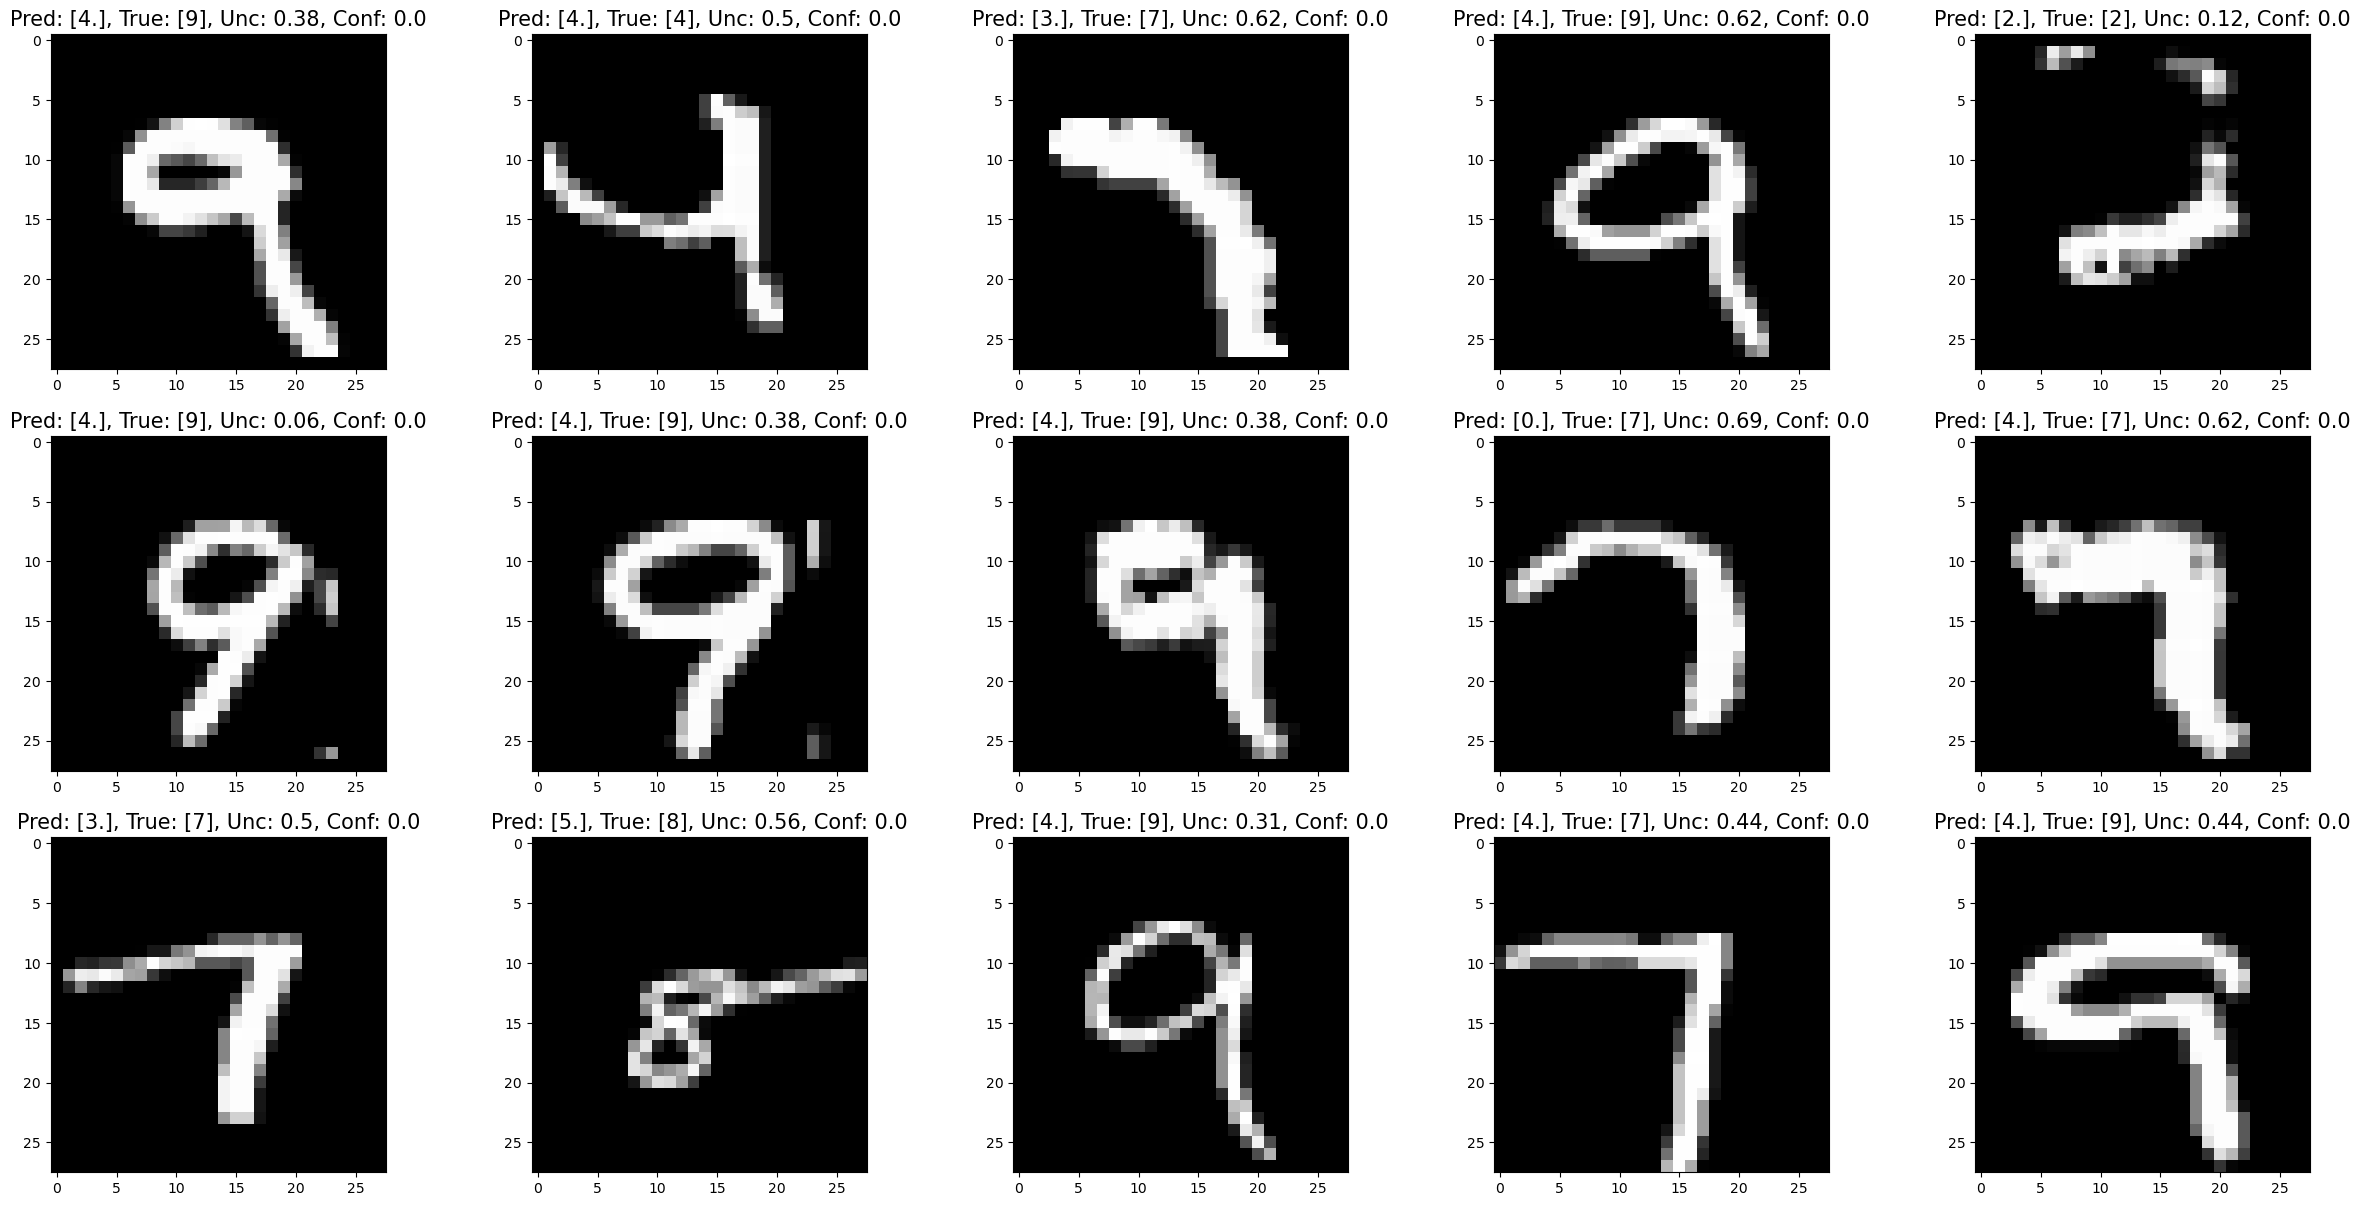

In [90]:
# print({k: v for k, v in RANDOM_FOREST_MODELS.items() if not isinstance(k[0], tuple) and k[1] == 0.75})

n_predictions = 1

evaluate_model_matrix(DATASETS, {
    k: v for k, v in RANDOM_FOREST_MODELS.items() if not isinstance(k[0], tuple) and k[1] == 0.75
}, n_predictions, title="numbers_classification")